# Résolution d'un problème d'optimisation linéaire avec Julia

Soit un problème simple de gestion d'energie incluant une batterie et une source PV. On utilise le package JuMP pour modéliser le problème et le solveur CPLEX pour le résoudre.

**Data** :  
- Puissance PV au pas horaire : $ p_t^{ld} $ 
- Puissance elec au pas horaire : $ p_t^{pv} $  
- Coût de la fourniture élec : $ c_t^{g,+} $

**Variable de controle** :  
- Puissance de la batterie : $ u_t=(p_t^b) $  

**Variable d'état** :  
- Etat de charge de la batterie : $ x_t=(soc_t^b) $  

**Variable de recours** :  
- Puissance du réseau externe : $ p_t^g $  

**Objectif** :  
- Minimiser la facture en supposant qu'on ne peut pas re-injecter sur le reseau ( $ p_t^{g,+} \ge 0 $ ) : 
$$ \min_{u_t \in U_{ad}}  \sum_{t=1}^T p_t^{g,+}.c_t^{g,+} $$


## Chargement des packages

In [1]:
# Optimisation
using JuMP, CPLEX

# Lecture CSV
using CSV

# Plot
using Seaborn

## Paramètres de simulation et chargement des données

In [2]:
# Parametres de simulation
dk = 1. # en h
horizon = 24.  # en h
nk=length(dk:dk:horizon) # nombre de pas de temps sur l'horizon

# Data
data_tuto = CSV.read("data_tuto.csv")


,data_ld_E,data_pv,pxGrid
,Float64,Float64,Float64
1,0.19928,0.0,0.1
2,0.19714,0.0,0.1
3,0.1961,0.0,0.1
4,0.20007,0.0,0.1
5,0.21283,0.0038314,0.1
6,0.24166,0.018764,0.1
7,0.28758,0.070853,0.1
8,0.3848,0.18369,0.1
9,0.49583,0.32953,0.2


## Creation des structures

In [3]:
# PV
struct Source
    pkWc # (kWc) puissance crete
    power # (kW) puissance
end

# Load
struct Load
    pMax # (kW) puissance max
    power # (kW) puissance
end

# Batterie
struct Batterie
    # Parametres
    Erated # (kWh) capacité
    pMaxCh # (kW) puissance max de charge
    pMaxDch # (kW) puissance max de décharge
    ηCh # (0-1) rendement de charge
    ηDch # (0-1) rendement de décharge
    socMin # (0-1) SOC min
    socMax # (0-1) SOC max
    socIni # (0-1) SOC initial
    # Variables
    power # (kW) puissance
    soc # (0-1) SOC
end

# Grid
struct Grid
    pxGrid # prix de l'élec (euros/kWh)
    pMax # (kW) puissance de soutirage max
    # Variable
    power # (kW) puissance
end

## Initialisation

In [22]:
# PV
pv = Source(60,60. * data_tuto.data_pv)

# Load
ld = Load(30., 30. * data_tuto.data_ld_E)

# Batterie
batt = Batterie(200., 300., 300., 0.8, 0.8, 0.2, 0.8, 0.5, zeros(nk,1), zeros(nk+1,1))
batt.soc[1] = batt.socIni

# Grid
grid = Grid(data_tuto.pxGrid, 100., zeros(nk,1))

Grid([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], 100.0, [0.0; 0.0; … ; 0.0; 0.0])

## Plot des données et du profil de prix

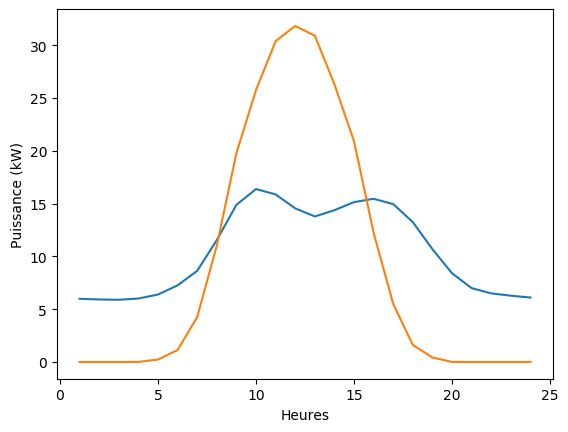

2-element Array{PyCall.PyObject,1}:
 PyObject Text(24.000000000000007, 0.5, 'Puissance (kW)')
 PyObject Text(0.5, 24.0, 'Heures')                      

In [23]:
# Plot des données
p1 = subplot(111)
p1.plot(dk:dk:horizon, ld.power)
p1.plot(dk:dk:horizon, pv.power)
p1.set(
    xlabel = "Heures",
    ylabel = "Puissance (kW)",
)

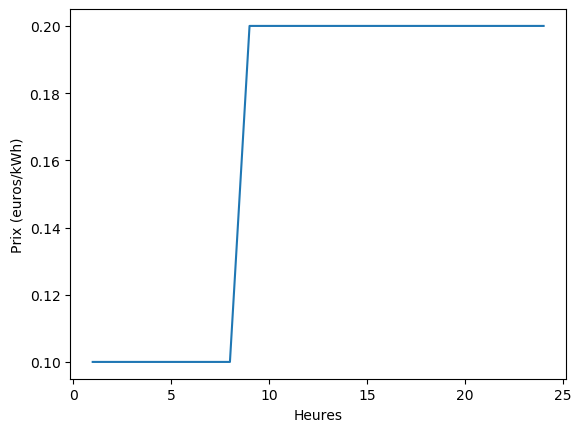

2-element Array{PyCall.PyObject,1}:
 PyObject Text(24.000000000000007, 0.5, 'Prix (euros/kWh)')
 PyObject Text(0.5, 24.0, 'Heures')                        

In [24]:
# Plot du profil de prix de l'électricité hp/hc
p2 = subplot(111)
p2.plot(dk:dk:horizon, grid.pxGrid)
p2.set(
    xlabel = "Heures",
    ylabel = "Prix (euros/kWh)",
)

## Fonction de control MILP

Modélisation avec JuMP et on utilise le solver CPLEX. Pour utiliser un autre solveur, modifier la commande dans "with_optimizer()"...


In [25]:
function controlMILP(batt::Batterie, grid::Grid, ld::Load, pv::Source, dk, nk)

    # Definition du model
    m = Model(with_optimizer(CPLEX.Optimizer))

    # Variables
    @variables(m, begin
            # Variable d'état
            soc[1:nk+1]
            # Variables de controle
            pCh_b[1:nk] <= 0.
            pDch_b[1:nk] >= 0.
            # Recours
            p_g[1:nk] >= 0.
            end)

    # Contraintes
    @constraints(m, begin
            # Variable d'état
            [k in 1:nk+1], soc[k] <= batt.socMax
            [k in 1:nk+1], soc[k] >= batt.socMin
            soc[1] == batt.socIni
            # Variable de controle
            [k in 1:nk], pCh_b[k] >= -batt.pMaxCh
            [k in 1:nk], pDch_b[k] <= batt.pMaxDch            
            # Dynamique
            [k in 1:nk], soc[k+1] == soc[k] - (pCh_b[k] * batt.ηCh + pDch_b[k] /  batt.ηDch ) * dk / batt.Erated     
            # Recours
            [k in 1:nk], ld.power[k] - pv.power[k] - pCh_b[k] - pDch_b[k] <= p_g[k] 
            end)
    
    # Objectif
    @objective(m, Min, sum(p_g[k] .* grid.pxGrid[k] for k in 1:nk) * dk)

    # Solve
    optimize!(m)

    return value.(pCh_b + pDch_b)

end

controlMILP (generic function with 1 method)

## Simulateur

In [26]:
# Calcul de la trajectoire de controle sur l'horizon 
controlPowerBatt = controlMILP(batt, grid, ld, pv, dk, nk);

# Simulation du micro-réseau sur l'horizon
for k=1:nk
    
    # Limitation en puissance
    batt.power[k] = max(min(0,controlPowerBatt[k]),-batt.pMaxCh) + min(max(0,controlPowerBatt[k]),batt.pMaxDch);
    
    # Dynamique de la batterie
    batt.soc[k+1] = batt.soc[k] - ( min(0,batt.power[k]) * batt.ηCh + max(0,batt.power[k]) / batt.ηDch ) * dk / batt.Erated;
    
    # Calcul de la puissance du réseau
    grid.power[k] = max(0,ld.power[k] - pv.power[k] - batt.power[k]);
    
end

# NB : Le modèle utilisé pour la simulation peut être différent du modèle d'optimisation qui est souvent simplifié pour
# limiter les temps de calcul. Dans notre cas, les deux modèles sont identiques...

Tried aggregator 1 time.
LP Presolve eliminated 99 rows and 1 columns.
Reduced LP has 48 rows, 96 columns, and 167 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000


## Plot des puissances et du SOC de la batterie

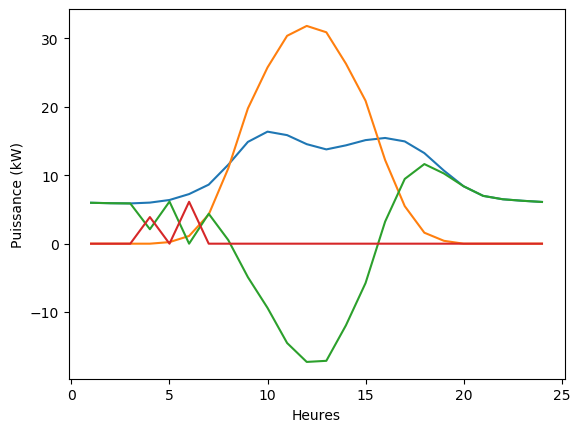

2-element Array{PyCall.PyObject,1}:
 PyObject Text(24.000000000000007, 0.5, 'Puissance (kW)')
 PyObject Text(0.5, 24.0, 'Heures')                      

In [27]:
# Plot des puissances
p3 = subplot(111)
p3.plot(dk:dk:horizon, ld.power)
p3.plot(dk:dk:horizon, pv.power)
p3.plot(dk:dk:horizon, batt.power)
p3.plot(dk:dk:horizon, grid.power)
p3.set(
    xlabel = "Heures",
    ylabel = "Puissance (kW)",
)

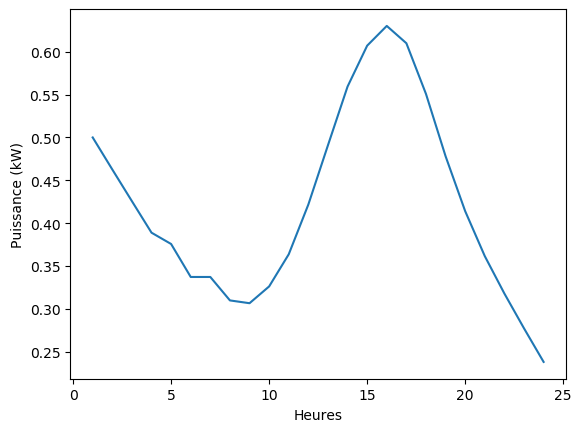

2-element Array{PyCall.PyObject,1}:
 PyObject Text(24.000000000000007, 0.5, 'Puissance (kW)')
 PyObject Text(0.5, 24.0, 'Heures')                      

In [28]:
# Plot des puissances
p4 = subplot(111)
p4.plot(dk:dk:horizon, batt.soc[1:end-1])
p4.set(
    xlabel = "Heures",
    ylabel = "Puissance (kW)",
)

## Calcul de la facture élec

In [29]:
facture = sum(grid.power .* grid.pxGrid) * dk

1.001316600000001